In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from IPython.display import HTML
import gradient as gd
import calibration as cal
import unwarp as uw
import color
import lines as ln
from moviepy.editor import VideoFileClip
%matplotlib inline

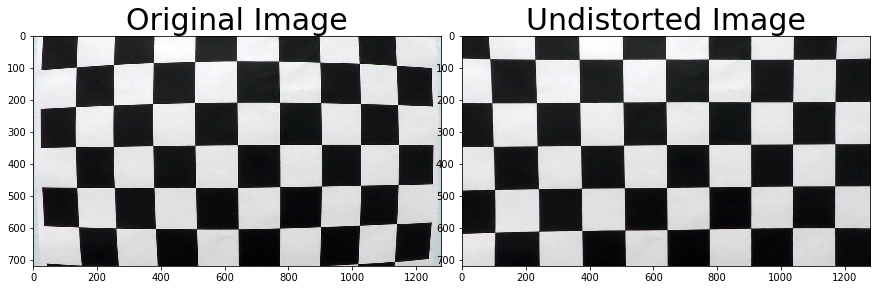

In [2]:
mtx, dist=cal.calibration('camera_cal')
img = cv2.imread('camera_cal/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

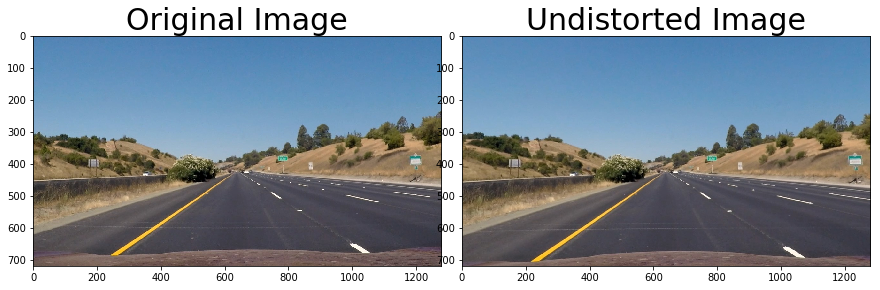

In [3]:
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

dst = cv2.undistort(img, mtx, dist, None, mtx)
 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

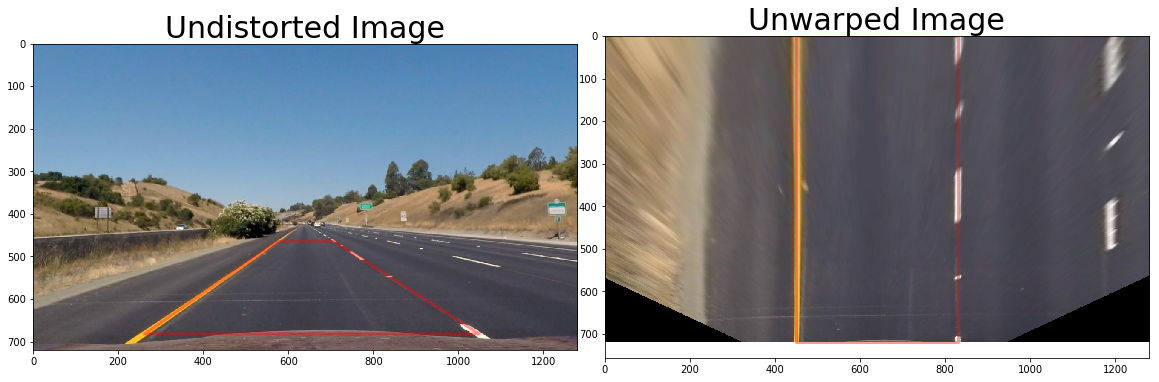

In [4]:
h,w = dst.shape[:2]

# define source and destination points for transform
rect_src = np.float32([(576,464),
                  (707,464), 
                  (262,682), 
                  (1049,682)])
rect_dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

img_unwarp, M, Minv = uw.unwarp(dst, rect_src, rect_dst)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(dst)
x = [rect_src[0][0],rect_src[2][0],rect_src[3][0],rect_src[1][0],rect_src[0][0]]
y = [rect_src[0][1],rect_src[2][1],rect_src[3][1],rect_src[1][1],rect_src[0][1]]
ax1.plot(x, y, color='#ff0000', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(img_unwarp)
x = [rect_dst[0][0],rect_dst[2][0],rect_dst[3][0],rect_dst[1][0],rect_dst[0][0]]
y = [rect_dst[0][1],rect_dst[2][1],rect_dst[3][1],rect_dst[1][1],rect_dst[0][1]]
ax2.plot(x, y, color='#ff0000', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax2.set_title('Unwarped Image', fontsize=30)

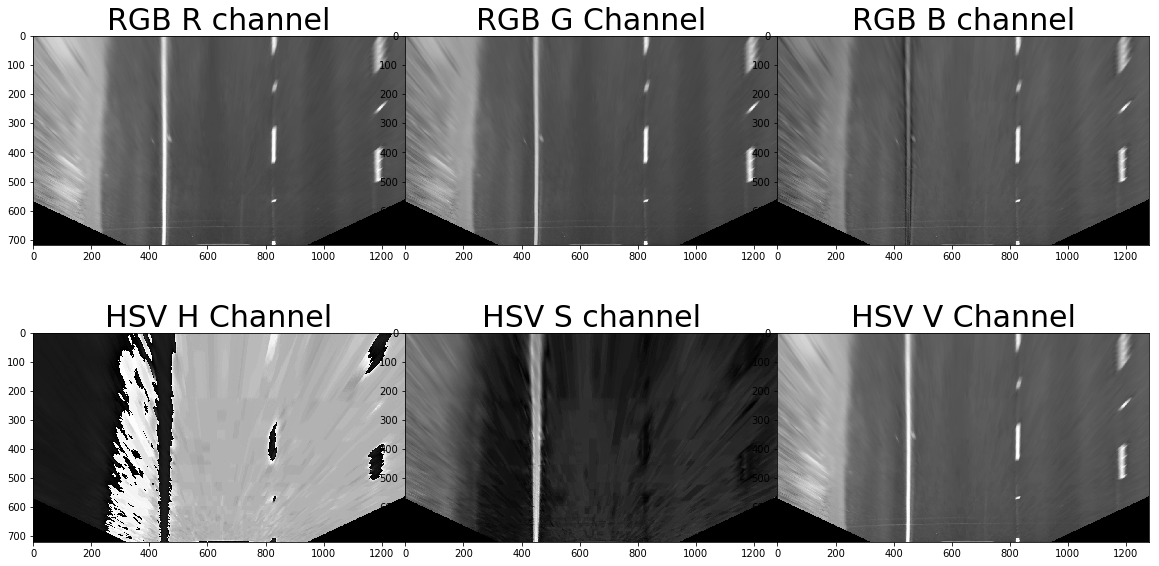

In [5]:

# Visualize multiple color space channels
img_unwarp_R = img_unwarp[:,:,0]
img_unwarp_G = img_unwarp[:,:,1]
img_unwarp_B = img_unwarp[:,:,2]
img_unwarp_HSV = cv2.cvtColor(img_unwarp, cv2.COLOR_RGB2HSV)
img_unwarp_H = img_unwarp_HSV[:,:,0]
img_unwarp_S = img_unwarp_HSV[:,:,1]
img_unwarp_V = img_unwarp_HSV[:,:,2]
fig, axs = plt.subplots(2,3, figsize=(20, 10))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
axs[0].imshow(img_unwarp_R, cmap='gray')
axs[0].set_title('RGB R channel', fontsize=30)
axs[1].imshow(img_unwarp_G, cmap='gray')
axs[1].set_title('RGB G Channel', fontsize=30)
axs[2].imshow(img_unwarp_B, cmap='gray')
axs[2].set_title('RGB B channel', fontsize=30)
axs[3].imshow(img_unwarp_H, cmap='gray')
axs[3].set_title('HSV H Channel', fontsize=30)
axs[4].imshow(img_unwarp_S, cmap='gray')
axs[4].set_title('HSV S channel', fontsize=30)
axs[5].imshow(img_unwarp_V, cmap='gray')
axs[5].set_title('HSV V Channel', fontsize=30)

In [6]:
img = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
dst = cv2.undistort(img, mtx, dist, None, mtx)
img_unwarp, M, Minv = uw.unwarp(dst, rect_src, rect_dst)

In [7]:
# Define the complete image processing pipeline, reads raw image and returns binary image with lane lines identified
# Import is rgp picture

def pipeline(img):
    
    # Undistort
    img_undis = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Perspective Transform
    img_unwarp, M, Minv = uw.unwarp(img_undis, rect_src, rect_dst)

    # Sobel Absolute (using default parameters)
    #img_sobelx = gd.abs_sobel_thresh(img_unwarp)

    # Sobel Magnitude (using default parameters)
    #img_sobelMag = gd.mag_thresh(img_unwarp)
    
    # Sobel Direction (using default parameters)
    #img_sobelDir = dir_thresh(img_unwarp)
    
    # HLS S-channel Threshold (using default parameters)
    #img_SThresh = hls_sthresh(img_unwarp)

    # HLS L-channel Threshold (using default parameters)
    img_l = color.hls_lthresh(img_unwarp)
    
     # HLS S-channel Threshold (using default parameters)
    img_s = color.hls_sthresh(img_unwarp)

    # RGB R-channel Threshold (using default parameters)
    img_r = color.rgb_rthresh(img_unwarp)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_l)
    combined[(img_r == 1)|((img_l == 1)&(img_s == 1))]=1
    
    return combined, Minv

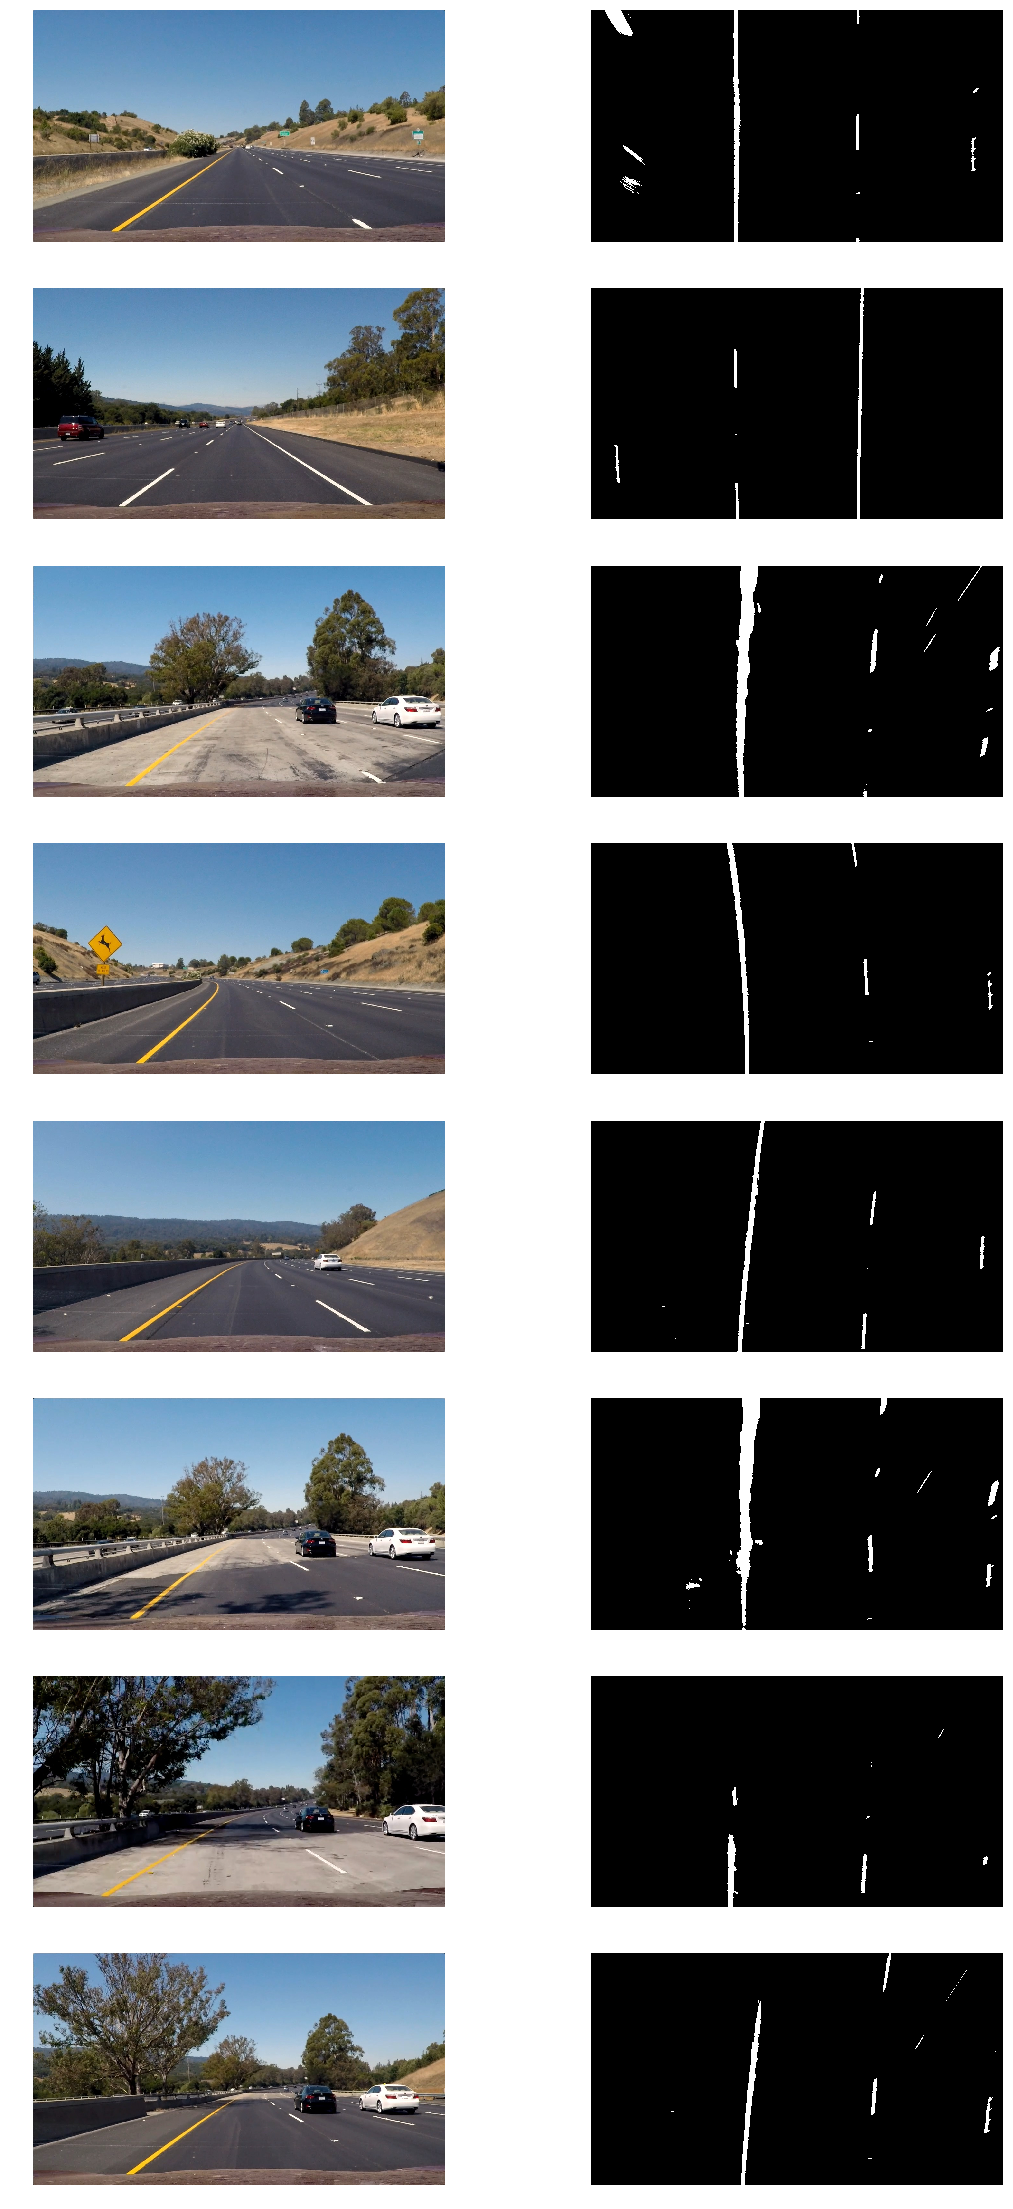

In [8]:

# Make a list of example images
images = glob.glob('test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(20, 40))
fig.subplots_adjust(hspace = .2, wspace=.001)
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, Minv = pipeline(img)
    axs[i,0].imshow(img)
    axs[i,0].axis('off')
    axs[i,1].imshow(img_bin, cmap='gray')
    axs[i,1].axis('off')
    i += 1

In [9]:
# Make a list of example images
#img = cv2.imread('test_images/test5.jpg')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img_bin, Minv = pipeline(img)
                
#ln.findlines(img_bin,True)

In [10]:
#Initialization
pre_right_fit=[];
pre_left_fit=[];
reinitial=True;

In [11]:
def drawMark(img,draw_pts,left_curverad,right_curverad,bias):
    color_warp = np.zeros_like(img).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
         
    cv2.fillPoly(color_warp, np.int_([draw_pts]), (0,255, 0))
   
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    textl = 'Left Curve Radius: ' + '{:04.2f}'.format(left_curverad) + 'm'
    textr = 'Right Curve Radius: ' + '{:04.2f}'.format(right_curverad) + 'm'
    textc = '{:04.2f}'.format(bias) + 'm' + ' From Center'
    cv2.putText(result, textl, (200,40), cv2.FONT_HERSHEY_DUPLEX, 2, [0,255,0], 1, cv2.LINE_AA)
    cv2.putText(result, textr, (200,100), cv2.FONT_HERSHEY_DUPLEX, 2, [0,255,0], 1, cv2.LINE_AA)
    cv2.putText(result, textc, (200,160), cv2.FONT_HERSHEY_DUPLEX, 2, [0,255,0], 1, cv2.LINE_AA)
    return result
    

In [12]:
def sanity(left_curverad,right_curverad):
    if left_curverad<100:
        return True
    if right_curverad<100:
        return True
    if abs(left_curverad-right_curverad)>10000:
        return True
    return False

In [13]:
def process_image(img):
    global pre_left_fit
    global pre_right_fit
    global reinitial
    new_img = np.copy(img)
    img_bin, Minv = pipeline(new_img)
    left_fit,right_fit,left_curverad,right_curverad,bias,draw_pts = ln.findlines(img_bin, pre_left_fit, pre_right_fit, reinitial)
    pre_left_fit = left_fit
    pre_right_fit = right_fit
    reinitial = sanity(left_curverad,right_curverad)
    return drawMark(img,draw_pts,left_curverad,right_curverad,bias)

In [ ]:
# Make a list of example images
images = glob.glob('test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),1, figsize=(20, 40))
fig.subplots_adjust(hspace = .2, wspace=.001)
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = process_image(img)
    axs[i].imshow(result)
    axs[i].axis('off')
    i += 1

In [15]:
video_output1 = 'videos/project_video_output.mp4'
video_input1 = VideoFileClip('videos/project_video.mp4')#.subclip(5,10)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video videos/project_video_output.mp4
[MoviePy] Writing video videos/project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [02:26<00:00,  8.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/project_video_output.mp4 

Wall time: 2min 27s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))